<a href="https://colab.research.google.com/github/aryan-at-ul/customer_segmentation/blob/main/som_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=4be2affa9031d302d04ff23c2c2be5e5285fd0c80a31f14a0392b3995bc56b81
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [ ]:
data_path = "/content/drive/MyDrive/customer_segmentation/segmentation data.csv"
#one can download csv from public folder and use it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from minisom import MiniSom
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_segmentation = pd.read_csv(data_path,index_col = 0)
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [ ]:
scalar = StandardScaler()
segmentation_std = scalar.fit_transform(df_segmentation)
segmentation_std.shape

# pca = PCA(n_components= 3)
# pca.fit(segmentation_std)

(2000, 7)

In [ ]:
# df_pca_comp = pd.DataFrame(data = pca.components_,
#                            columns = df_segmentation.columns.values,
#                            index = ['Component 1','Component 2','Component 3'])

# df_pca_comp = df_pca_comp.values

In [ ]:
som_shape = (1, 4)
som = MiniSom(som_shape[0], som_shape[1], segmentation_std.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(segmentation_std, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 2.094106025897903


In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in segmentation_std]).T
print(winner_coordinates)
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
print(cluster_index)

[[0 0 0 ... 0 0 0]
 [2 1 0 ... 0 0 0]]
[2 1 0 ... 0 0 0]


In [ ]:
df_som = pd.DataFrame(data = cluster_index,
                           columns = ['Som Segment']
                         )

In [ ]:
df_seg_som = pd.concat([df_segmentation.reset_index(drop = True),df_som],axis = 1)
df_seg_som.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Som Segment
0,0,0,67,2,124670,1,2,2
1,1,1,22,1,150773,1,2,1
2,0,0,49,1,89210,0,0,0
3,0,0,45,1,171565,1,1,2
4,0,0,53,1,149031,1,1,3


In [ ]:
df_seg_som_freq = df_seg_som.groupby(['Som Segment']).mean()
df_seg_som_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Som Segment,,,,,,,
0,0.567861,0.524430,34.035831,1.008686,97550.053203,0.360478,0.056460
1,0.871560,0.988532,37.681193,1.474771,138899.866972,1.116972,1.135321
2,0.008811,0.092511,43.779736,1.079295,176633.563877,1.731278,1.563877
3,0.021635,0.139423,33.903846,0.622596,123579.514423,0.983173,1.384615


In [ ]:
df_seg_som_freq['N observations'] = df_seg_som[['Som Segment','Sex']].groupby(['Som Segment']).count()
df_seg_som_freq['Proportion of Observations'] = df_seg_som_freq['N observations'] / df_seg_som_freq['N observations'].sum()

df_seg_som_freq = df_seg_som_freq.rename({
    0:'fewer-opportunities',
    1:'well-off',
    2:'Career focus',
    3:'standard'
})

df_seg_som_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N observations,Proportion of Observations
Som Segment,,,,,,,,,
fewer-opportunities,0.567861,0.524430,34.035831,1.008686,97550.053203,0.360478,0.056460,921,0.4605
well-off,0.871560,0.988532,37.681193,1.474771,138899.866972,1.116972,1.135321,436,0.2180
Career focus,0.008811,0.092511,43.779736,1.079295,176633.563877,1.731278,1.563877,227,0.1135
standard,0.021635,0.139423,33.903846,0.622596,123579.514423,0.983173,1.384615,416,0.2080


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Segmentation using SOM')

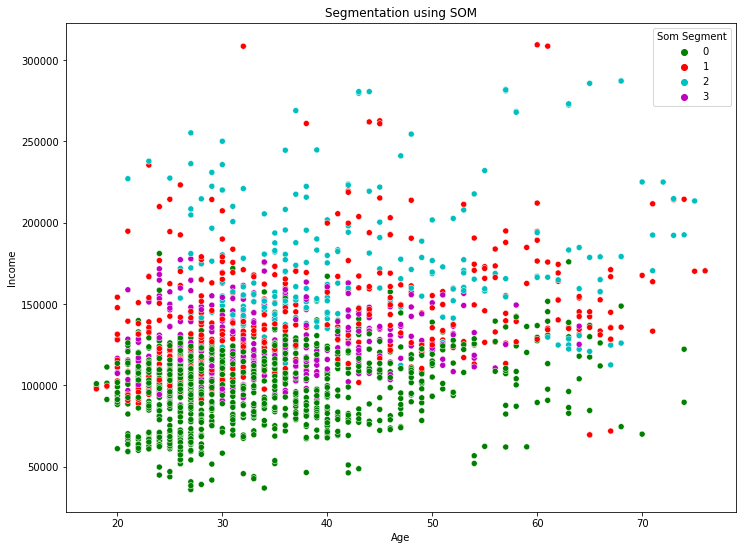

In [ ]:
x_axis = df_seg_som['Age']
y_axis = df_seg_som['Income']

plt.figure(figsize = (12,9))
sns.scatterplot(x_axis,y_axis, hue = df_seg_som['Som Segment'], palette = ['g','r','c','m'])
plt.title('Segmentation using SOM')

In [ ]:
print(f'silhouette_score: {silhouette_score(segmentation_std,cluster_index)}')

silhouette_score: 0.16987474239644024
